In [1]:
import neuraltda.topology2 as tp2
import pandas as pd
from joblib import Parallel, delayed
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import datetime
import pickle
import glob
import os
from ephys import core, events, clust
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import h5py as h5
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [18]:
# Rebin with 1ms, no overlap, start+2500ms to end+500ms, correct trials
block_path = '/home/brad/emily/P01S15/'
winsize = 1.0
dtover = 0.0
segment = [2500, 500]

cluster_group = ['Good', 'MUA']
widenarrow_threshold = 0.000230 # sw threshold in seconds

spikes = core.load_spikes(block_path)
trials = events.load_trials(block_path)
fs = core.load_fs(block_path)

# Get wide/narrow clusters
clusters = core.load_clusters(block_path)
clusters_list = clusters[clusters.quality.isin(cluster_group)]['cluster'].unique()
(wide, narrow) = clust.get_wide_narrow(block_path, clusters_list, widenarrow_threshold)

# Get Correct/Incorrect Trials
correctTrials = trials[trials['correct']==True]
incorrectTrials = trials[trials['correct']==False]
passiveTrials = trials[-(trials['correct'].isin([True, False]))]

# Bin Correct Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, correctTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-correct')
bdf_correct = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf))

# Bin Incorrect Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, incorrectTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-incorrect')
bdf_incorrect = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf))

# Bin Passive Trials
bfdict = tp2.do_dag_bin_lazy(block_path, spikes, passiveTrials, clusters, fs, winsize,
                                    segment, cluster_group=['Good', 'MUA'],
                                    dt_overlap=dtover, comment='SD-emily-reanalysis-passive')
bdf_passive = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print('BDF: {}'.format(bdf))

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher

Data Not already binned
BDF: /home/brad/emily/P01S15/binned_data/win-1.0_dtovr-0.0_seg-2500-500-SD-emily-reanalysis/20170629T213232Z-1.0-0.0.binned
Data Not already binned


--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-pac

BDF: /home/brad/emily/P01S15/binned_data/win-1.0_dtovr-0.0_seg-2500-500-SD-emily-reanalysis/20170629T213232Z-1.0-0.0.binned
Data Not already binned


--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-pac

Activity Tensor: Duration <= 0
Activity Tensor: Duration <= 0
BDF: /home/brad/emily/P01S15/binned_data/win-1.0_dtovr-0.0_seg-2500-500-SD-emily-reanalysis/20170629T213232Z-1.0-0.0.binned


In [22]:
# contexts:
context_stimuli = {
    'A_hi': 'T40S40D3',
    'A_lo': 'T3S3D40',
    'AS_hi': 'T40S40D-1',
    'AS_lo': 'T3S3D-1',
    'AX_hi': 'T40S40D3',
    'AX_lo': 'T3S3D40',
    'P_hi': 'T40S40D3',
    'P_lo': 'T3S3D40'
}
context_bdf = {
    'A_hi': bdf_correct,
    'A_lo': bdf_correct,
    'AS_hi': bdf_correct,
    'AS_lo': bdf_correct,
    'AX_hi': bdf_incorrect,
    'AX_lo': bdf_incorrect,
    'P_hi': bdf_passive,
    'P_lo': bdf_passive
}
contexts = [
    'A_hi',
    'A_lo',
    'AS_hi',
    'AS_lo',
    'AX_hi',
    'AX_lo',
    'P_hi',
    'P_lo'
]

In [7]:
# compute average psths
avg_psths = {}
with h5.File(bdf, 'r') as binned_data:
    for context in contexts.keys():
        stim = contexts[context]
        fulldata = np.array(binned_data[stim]['pop_tens'])
        avg_psth = np.mean(fulldata, axis=2)
        avg_psths[str(context)] = avg_psth
    binned_clusters = np.array(binned_data[stim]['clusters'])

In [23]:
avg_psths = {}
for context in contexts:
    with h5.File(context_bdf[context], 'r') as binned_data:
        stim = context_stimuli[context]
        fulldata = np.array(binned_data[stim]['pop_tens'])
        avg_psth = np.mean(fulldata, axis=2)
        avg_psths[str(context)] = avg_psth
        binned_clusters = np.array(binned_data[stim]['clusters'])

In [62]:
# Compute MSEs:
from scipy import signal

def mse(psth_a, psth_b, psth_c, psth_d):
    la = psth_a.shape
    lb = psth_b.shape
    lc = psth_c.shape
    ld = psth_d.shape
    
    new_a = np.zeros((la[0], max(la[1], lb[1])))
    new_b = np.zeros((lb[0], max(la[1], lb[1])))
    new_a[:la[0], :la[1]] = psth_a
    new_b[:lb[0], :lb[1]] = psth_b
    
    new_c = np.zeros((lc[0], max(lc[1], ld[1])))
    new_d = np.zeros((ld[0], max(lc[1], ld[1])))
    new_c[:lc[0], :lc[1]] = psth_c
    new_d[:ld[0], :ld[1]] = psth_d
    
    mse_ab = np.sum(np.square(psth_a - psth_b), axis=1) /  (psth_a.shape[1])
    mse_cd = np.sum(np.square(psth_c - psth_d), axis=1) /  (psth_c.shape[1])
    return mse_ab + mse_cd

def mse_vec(psth_a, psth_b, psth_c, psth_d):
    
    la = psth_a.shape
    lb = psth_b.shape
    lc = psth_c.shape
    ld = psth_d.shape
    new_a = np.zeros((la[0], max(la[1], lb[1])))
    new_b = np.zeros((lb[0], max(la[1], lb[1])))
    new_a[:la[0], :la[1]] = psth_a
    new_b[:lb[0], :lb[1]] = psth_b
    
    new_c = np.zeros((lc[0], max(lc[1], ld[1])))
    new_d = np.zeros((ld[0], max(lc[1], ld[1])))
    new_c[:lc[0], :lc[1]] = psth_c
    new_d[:ld[0], :ld[1]] = psth_d
    
    mse_ab = np.square(new_a - new_b)
    mse_cd = np.square(new_c - new_d)
    return mse_ab + mse_cd

def exp_filt(vec, tau):
    M=51
    win = signal.exponential(M, 0, tau, False)
    return np.convolve(vec, win, mode='same')
    

In [48]:
MSE_targ = mse(avg_psths['A_hi'], avg_psths['AS_hi'], avg_psths['A_lo'], avg_psths['AS_lo'])
MSE_dist = mse(avg_psths['A_hi'], avg_psths['AS_lo'], avg_psths['A_lo'], avg_psths['AS_hi'])
MSE_diff = MSE_dist - MSE_targ

MSE_targ_vec = mse_vec(avg_psths['A_hi'], avg_psths['AS_hi'], avg_psths['A_lo'], avg_psths['AS_lo'])
MSE_dist_vec = mse_vec(avg_psths['A_hi'], avg_psths['AS_lo'], avg_psths['A_lo'], avg_psths['AS_hi'])
MSE_diffC_vec = MSE_dist_vec - MSE_targ_vec

MSE_targX_vec = mse_vec(avg_psths['AX_hi'], avg_psths['AS_hi'], avg_psths['AX_lo'], avg_psths['AS_lo'])
MSE_distX_vec = mse_vec(avg_psths['AX_hi'], avg_psths['AS_lo'], avg_psths['AX_lo'], avg_psths['AS_hi'])
MSE_diffX_vec = MSE_dist_vec - MSE_targ_vec

MSE_targP_vec = mse_vec(avg_psths['P_hi'], avg_psths['AS_hi'], avg_psths['P_lo'], avg_psths['AS_lo'])
MSE_distP_vec = mse_vec(avg_psths['P_hi'], avg_psths['AS_lo'], avg_psths['P_lo'], avg_psths['AS_hi'])
MSE_diffP_vec = MSE_dist_vec - MSE_targ_vec

MSE_diffs = np.stack([MSE_diffC_vec, MSE_diffX_vec, MSE_diffP_vec], axis=-1)
MSE_max = np.amax(MSE_diffs, axis=(1,2)) #get absolute maximum across bins/conditions for each cell

MSE_diffs_normalized = np.divide(MSE_diffs, np.tile(MSE_max[:, np.newaxis, np.newaxis], (1, MSE_diffs.shape[1], 3)))
MSE_diffs_norm_mean = np.nanmean(MSE_diffs_normalized, axis=1)

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


In [56]:
# compute attention modulation
from scipy.stats import wilcoxon

MSE_psth_passive = mse_vec(avg_psths['P_hi'], avg_psths['P_lo'], avg_psths['P_hi'], avg_psths['P_lo'])/2.0
MSE_psth_correct = mse_vec(avg_psths['A_hi'], avg_psths['A_lo'], avg_psths['A_hi'], avg_psths['A_lo'])/2.0
for cell in range(MSE_psth_correct.shape[0]):
    
    (T, p) = wilcoxon(MSE_psth_passive[cell, :2499], MSE_psth_correct[cell, :2499])
    eff_size = T / np.sqrt(2500)
    sig = ''
    if p < 0.05:
        sig = 'X'
    print('p: {:6.6f}     Effect Size: {:8.1f}  '.format(p, eff_size)+sig)

p: 0.000002     Effect Size:   7682.0  X
p: 0.000014     Effect Size:  21564.4  X
p: 0.117988     Effect Size:     13.6  
p: 0.000000     Effect Size:  20737.3  X
p: 0.929144     Effect Size:    536.5  
p: 0.673565     Effect Size:   7034.0  
p: 0.055778     Effect Size:     66.6  
p: 0.001723     Effect Size:     41.9  X
p: 0.724826     Effect Size:      5.2  
p: 0.278000     Effect Size:    385.7  
p: 0.255435     Effect Size:     98.5  
p: 0.446882     Effect Size:    303.7  
p: 0.739640     Effect Size:   1624.0  
p: 0.000626     Effect Size:    842.5  X
p: 0.000000     Effect Size:  25079.4  X
p: 0.047604     Effect Size:    155.0  X
p: 0.330358     Effect Size:   8488.1  
p: 0.000077     Effect Size:   4520.4  X
p: 0.292840     Effect Size:    160.3  
p: 0.179287     Effect Size:     22.8  
p: 0.718308     Effect Size:    600.6  
p: 0.043715     Effect Size:     19.7  X
p: 0.000590     Effect Size:    173.1  X
p: 0.000461     Effect Size:     28.2  X
p: 0.004241     Effect Size: 

In [76]:
# compute significantly modulated bins:

filt_poptens = {}
for context in contexts:
    with h5.File(context_bdf[context], 'r') as binned_data:
        stim = context_stimuli[context]
        fulldata = np.array(binned_data[stim]['pop_tens'])
        filt_data = np.zeros(np.shape(fulldata))
        for cell in range(fulldata.shape[0]):
            for trial in range(fulldata.shape[2]):
                filt_data[cell, :, trial] = exp_filt(fulldata[cell, :, trial], 8.0)
                
        filt_poptens[str(context)] = filt_data
        binned_clusters = np.array(binned_data[stim]['clusters'])
        
dprimes = (np.mean(filt_poptens['A_hi'], axis=2) - np.mean(filt_poptens['A_lo'], axis=2))
dprimes = np.divide(dprimes, np.sqrt(np.var(filt_poptens['A_hi'], axis=2) + np.var(filt_poptens['A_lo'], axis=2) / 2 ))
dprimes

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


array([[-0.14306493, -0.14306493, -0.14306493, ..., -0.05574333,
        -0.05574333, -0.05574333],
       [ 0.13094104, -0.00603516, -0.00603516, ...,  0.26434212,
         0.26434212,  0.26434212],
       [ 0.12014278,  0.12014278,  0.12014278, ...,         nan,
                nan,         nan],
       ..., 
       [        nan,         nan,         nan, ..., -0.26726124,
        -0.26726124, -0.26726124],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.26726124, -0.26726124, -0.26726124, ...,         nan,
                nan,         nan]])

In [45]:
# Break into wide/narrow
wide_mse_diff = MSE_diffs_norm_mean[np.in1d(binned_clusters, wide)]
narrow_mse_diff = MSE_diffs_norm_mean[np.in1d(binned_clusters, narrow)]

#Print wide
print('Wide Clusters')
for ind, val in enumerate(wide_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))
    
#Print Narrow
print('Narrow Clusters')
for ind, val in enumerate(narrow_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))

Wide Clusters
Cluster:   0    MSE Diff:     0.0009
Cluster:   1    MSE Diff:        nan
Cluster:   2    MSE Diff:     0.0010
Cluster:   3    MSE Diff:     0.0006
Cluster:   4    MSE Diff:     0.0004
Cluster:   5    MSE Diff:     0.0006
Cluster:   6    MSE Diff:    -0.0023
Cluster:   7    MSE Diff:    -0.0008
Cluster:   8    MSE Diff:     0.0003
Cluster:   9    MSE Diff:    -0.0001
Cluster:  10    MSE Diff:    -0.0025
Cluster:  11    MSE Diff:     0.0004
Cluster:  12    MSE Diff:     0.0012
Cluster:  13    MSE Diff:    -0.0017
Cluster:  14    MSE Diff:        nan
Cluster:  15    MSE Diff:     0.0021
Cluster:  16    MSE Diff:    -0.0001
Cluster:  17    MSE Diff:    -0.0004
Cluster:  18    MSE Diff:    -0.0002
Cluster:  19    MSE Diff:     0.0012
Cluster:  20    MSE Diff:     0.0001
Cluster:  21    MSE Diff:     0.0008
Cluster:  22    MSE Diff:    -0.0016
Cluster:  23    MSE Diff:    -0.0006
Cluster:  24    MSE Diff:        nan
Cluster:  25    MSE Diff:    -0.0020
Cluster:  26    MSE Diff

In [25]:
# Break into wide/narrow
wide_mse_diff = MSE_diff[np.in1d(binned_clusters, wide)]
narrow_mse_diff = MSE_diff[np.in1d(binned_clusters, narrow)]

#Print wide
print('Wide Clusters')
for ind, val in enumerate(wide_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))
    
#Print Narrow
print('Narrow Clusters')
for ind, val in enumerate(narrow_mse_diff):
    print("Cluster: {:3.0f}    MSE Diff: {:10.4f}".format(float(ind), val))

Wide Clusters
Cluster:   0    MSE Diff:    15.4085
Cluster:   1    MSE Diff:     0.0000
Cluster:   2    MSE Diff:    47.0878
Cluster:   3    MSE Diff:     6.9424
Cluster:   4    MSE Diff:     4.5852
Cluster:   5    MSE Diff:     3.5503
Cluster:   6    MSE Diff:   -13.0943
Cluster:   7    MSE Diff:    -4.3264
Cluster:   8    MSE Diff:    35.2727
Cluster:   9    MSE Diff:    -0.4168
Cluster:  10    MSE Diff:   -28.9627
Cluster:  11    MSE Diff:     2.2998
Cluster:  12    MSE Diff:    14.9916
Cluster:  13    MSE Diff:   -20.9567
Cluster:  14    MSE Diff:     0.0000
Cluster:  15    MSE Diff:    12.1025
Cluster:  16    MSE Diff:    -0.4600
Cluster:  17    MSE Diff:    -2.1992
Cluster:  18    MSE Diff:    -2.2854
Cluster:  19    MSE Diff:    14.2586
Cluster:  20    MSE Diff:     0.4312
Cluster:  21    MSE Diff:     9.1128
Cluster:  22    MSE Diff:    -9.1847
Cluster:  23    MSE Diff:    -3.5934
Cluster:  24    MSE Diff:    -0.0000
Cluster:  25    MSE Diff:   -12.3469
Cluster:  26    MSE Diff

In [28]:
MSE_diff_vec.shape

(74, 2499)

In [11]:
a_h = np.random.standard_normal((20, 100))
as_h = np.random.standard_normal((20, 100))
a_l = np.random.standard_normal((20, 100))
as_l = np.random.standard_normal((20, 100))

mse_t = mse(a_h, as_h, a_l, as_l)
mse_d = mse(a_h, as_l, a_l, as_h)
mse_diff = mse_d - mse_t

In [12]:
mse_diff

array([-20.25190463,  60.57024706, -38.27126792, -39.20822378,
        34.22506067, -21.56016953, -17.54711924,  56.44565946,
       -21.48444559,  -7.82825565,  89.79055453,  15.06173692,
        24.89982774, -17.02510418, -24.18807837,  52.66583291,
       -32.68713435,  48.00001554, -43.18510708,  11.15946077])

In [57]:
clusters_list

array([  2,   5,   6,   9,  10,  11,  12,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  24,  27,  28,  31,  32,  33,  37,  41,  54,  57,
        58,  59,  60,  61,  63,  64,  65,  66,  67,  69,  70,  72,  75,
        81,  83,  84,  86,  87,  90,  91,  92,  97,  98,  99, 101, 102,
       104, 106, 107, 108, 112, 113, 115, 118, 119, 120, 121, 128, 131,
       132, 136, 139, 140, 141, 145, 148, 149, 150])

In [73]:
t = 1.0*(np.random.rand(100) > 0.9)

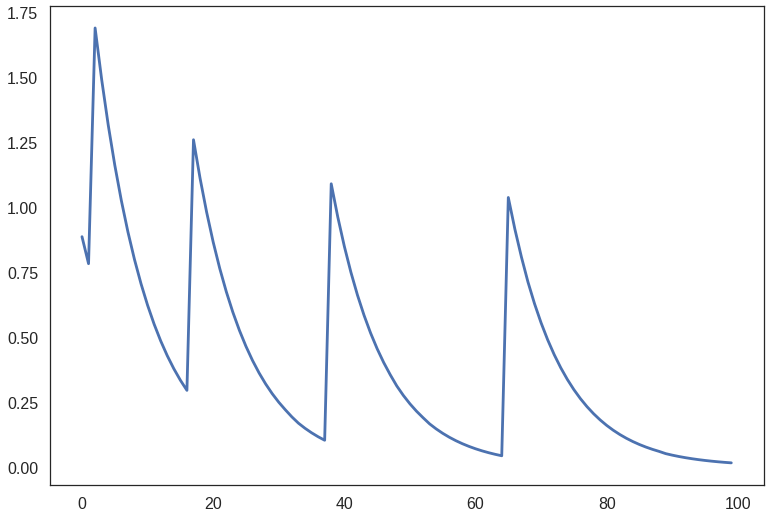

In [74]:
tf = exp_filt(t, 8.0)
plt.plot(tf)